## Update discussion 

## Update; 
### abbreviation update 
- FieldPosition and PossessionTeam use ARZ, BLT, CLV, HST
- VisitorTeamAbbr and HomeTeamAbbr use ARI, BAL, CLE, HOU
- This may or may not impact your approach -- in my post here, where I standardize the field so that each possession team is working left to right, manually tweaking these names is helpful.

### Orientation variable from 2017 is not reliable. 
- Consider the 2019 season and 2018 season to look similar though.

### Speed (S) is most similar in 2019 to 2018. 
- In 2017, slightly different RFID tags were used for the player tracking data.

### Orientation and Dir directions :Accuarcy

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display,HTML,Image, display_png
import pickle
import re
from itertools import zip_longest
from collections import Counter
import datetime
from datetime import datetime as dt
import copy
from functools import reduce
from tqdm import tqdm_notebook as tqdm
import os
import multiprocessing

In [2]:
import keras
import tensorflow.keras
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgbm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Using TensorFlow backend.
/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 500)

In [4]:
df = pd.read_csv('data/train.csv',low_memory=False)
# df = pd.read_csv("../input/nfl-big-data-bowl-2020/train.csv",low_memory=False)

In [5]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.910,34.840,1.690,1.130,0.400,81.990,177.180,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.000,77.000,8,SW
1,2017090700,20170907000118,away,74.670,32.640,0.420,1.350,0.010,27.610,198.700,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.000,77.000,8,SW
2,2017090700,20170907000118,away,74.000,33.200,1.220,0.590,0.310,3.010,202.730,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.000,77.000,8,SW
3,2017090700,20170907000118,away,71.460,27.700,0.420,0.540,0.020,359.770,105.640,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.000,77.000,8,SW
4,2017090700,20170907000118,away,69.320,35.420,1.820,2.430,0.160,12.630,164.310,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.000,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.000,77.000,8,SW


### 特徴量チェック

### 各種時刻修正と作成
- 型変換
- GameClock時間帯に変換
    - 時間帯は自分で指定

In [6]:

for _col in ['TimeHandoff','TimeSnap']:
    df[_col] = pd.to_datetime(df[_col],format='%Y-%m-%dT%H:%M:%S.000Z')
df.PlayerBirthDate = pd.to_datetime(df.PlayerBirthDate,format='%m/%d/%Y')
df.GameClock = pd.to_datetime(df.GameClock,format='%H:%M:%S')

In [7]:
df.GameClock = df.GameClock.dt.time
df['GameClockTimeAsDatetime'] =  str(dt.today().date()) +' ' +(df.GameClock).astype(str)
df.GameClockTimeAsDatetime = pd.to_datetime(df.GameClockTimeAsDatetime)#'%Y-%m-%d %H:%M:%S'
ls_bins_dt = []
ls_bins_str = ['00:00:00','06:00:00','09:00:00','12:00:00','15:00:00','18:00:00','21:00:00','23:59:59']
for _str_time in ls_bins_str:
    ls_bins_dt.append(dt.strptime((str(dt.today().date()) +' '+_str_time),'%Y-%m-%d %H:%M:%S'))
    
ls_bins_label = ['({}, {}]'.format(ls_bins_str[i-1], ls_bins_str[i]) for i in range(1, len(ls_bins_str))]
base_time = pd.to_datetime( dt.strptime( str(dt.today().date()) +' 00:00:00' ,'%Y-%m-%d %H:%M:%S'))
df['GameClockTimeZone'] = pd.cut((df.GameClockTimeAsDatetime-base_time).dt.total_seconds(),
                   bins=list(map(lambda x: (x-base_time).total_seconds(),ls_bins_dt)),
                   labels=ls_bins_label)
del df['GameClockTimeAsDatetime']
del df['GameClock']


## 風向き修正
- 風向きのばらつきを考慮(数値へ)
- 書いていること以上の入力はせず、ZeroPdding実施

In [8]:
_idx = df[df.WindSpeed.isin(['E','SE','SSW'])==True].index
_tmp = df.loc[_idx,'WindSpeed']
df.loc[_idx,'WindSpeed'] = df.loc[_idx,'WindDirection']
df.loc[_idx,'WindDirection'] = _tmp

In [9]:
dct_direction_short = {
    'south':'s',
    'west':'w',
    'east':'e',
    'north':'n'
}
def clean_wind_direction(_v):
    _v = _v.lower()
    _v = _v.replace('from','')
    for key_direc , value_dirc in  dct_direction_short.items():
        _v = _v.replace(key_direc,value_dirc)
    for _str in [' ','.','-','/']:
        _v = _v.replace(_str,'')
    return _v

In [10]:
for _drct in  dct_direction_short.values():
    df['direction_'+_drct] = df.WindDirection.str.count(_drct)/(df.WindDirection.str.len()).astype(float)

In [11]:
df.WindDirection = df.WindDirection.fillna('None')
ls_winddir = ['direction_'+direction_short for direction_short  in dct_direction_short.values()]
df.WindDirection = df.WindDirection.apply(lambda x: clean_wind_direction(x))

In [12]:
['direction_'+direction_short for direction_short  in dct_direction_short.values()]
df[ls_winddir] = df[ls_winddir].fillna(0)

In [13]:
del df['WindDirection']

## 風速修正
- 表記ゆれを一部修正
- ”-”の文字はavgをとる

In [14]:
df.WindSpeed = df.WindSpeed.astype(str)

In [15]:
df.loc[df.WindSpeed.isnull(),'WindSpeed'] = '0'
df.loc[df.WindSpeed == 'Calm','WindSpeed'] = '0'

In [16]:
df.loc[df.WindSpeed =='15 gusts up to 25','WindSpeed'] ='20'
_idx = df.loc[df.WindSpeed.str.contains('-')==True].index
_tmp = df.loc[_idx,'WindSpeed']
_tmp = _tmp.str.split('-',expand=True).astype(int)
df.loc[_idx,'WindSpeed'] = (_tmp[0] + _tmp[1] )/2.0

In [17]:
df.WindSpeed = df.WindSpeed.replace('[^0-9]+','', regex=True)

In [18]:
df = df[df.WindSpeed!='']
df.WindSpeed = df.WindSpeed.astype(float)

## studiumについて
- 表記ゆれの途中で、単語の出現を以て、外か外ではないか判定

In [19]:
#ここはふざけている
#Cloudyは天気について記入されている
set(df.loc[df.Stadium=='TIAA Bank Field'].StadiumType)

{'Bowl', 'Cloudy', 'Open', 'Outdoor', nan}

In [20]:
df.loc[df.Stadium=='TIAA Bank Field','StadiumType'] = 'outdoor'

In [21]:
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
#     txt = re.sub(' +', ' ', txt)
#     txt = txt.strip()
    txt = txt.replace(' ', ',')
    txt = txt.replace('-', ',')
    txt = txt.replace('.', ',')
    txt = txt.replace('domed', 'dome')
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'retr')
    txt = txt.replace(',,,', ',') 
    txt = txt.replace(',,', ',')
    return txt

In [22]:
#厳密に判定することは不可能なので、圧縮
def judge_StadiumType(txt):
    if txt!=txt:
        return 'open'
    #openかCloseかでまず決まる
    if 'open' in txt:
        return 'open'
    if 'close' in txt:
        return 'close'
    #indoorとoutdoor
    if 'outdoor' in txt:
        return 'open'
    if 'indoor' in txt:
        return 'close'
    #建物の特徴のルール
    if 'dome' in txt:
        return 'close'
    if 'roof' in txt:
        return 'close'
    if 'field' in txt:
        return 'open'
    #他
    return 'open'

In [23]:
df['StadiumType'] = df.StadiumType.apply(lambda _txt :clean_StadiumType(_txt))
df['StadiumTypeFeature1'] = df.StadiumType.apply(lambda _txt :judge_StadiumType(_txt))

In [24]:
#確認済み
set(df.loc[df.GameWeather.isin(['Indoor']),'StadiumType'])

set()

In [25]:
del df['StadiumType']

## turf : description of the field surface
-  状態のことを示している。が難しい処理は実施しないで、人工or 天然でまとめる

In [26]:
#from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

df['Turf'] = df['Turf'].map(Turf)
df['Turf'] = df['Turf'] == 'Natural'

## Poseess
- ボールを所持しているかチームにいて
- 年で表記ゆれがある。（２カラムを比較して一致しない場合がある）

In [27]:

df[(df['PossessionTeam']!=df['HomeTeamAbbr']) & (df['PossessionTeam']!=df['VisitorTeamAbbr'])][['PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr']]

,PossessionTeam,HomeTeamAbbr,VisitorTeamAbbr
2992,BLT,CIN,BAL
2993,BLT,CIN,BAL
2994,BLT,CIN,BAL
2995,BLT,CIN,BAL
2996,BLT,CIN,BAL
...,...,...,...
509669,ARZ,SEA,ARI
509670,ARZ,SEA,ARI
509671,ARZ,SEA,ARI
509672,ARZ,SEA,ARI


In [28]:
set(df.VisitorTeamAbbr.unique())  == set(df.HomeTeamAbbr.unique()) 

False

In [29]:
set(df.PossessionTeam.unique())  - set(df.HomeTeamAbbr.unique())
ls_team_pos, ls_team_home = list(df.PossessionTeam.unique()),  list(df.HomeTeamAbbr.unique())
ls_team_home.append('MIN')
(ls_team_pos).sort(),ls_team_home.sort()
print(len(ls_team_home),len(ls_team_pos))

31 32


In [30]:
df_tmp = pd.DataFrame({_order : [_team_pos,_team_home] for _order,(_team_pos, _team_home) in  enumerate(zip_longest(ls_team_pos,ls_team_home))}).T
df_tmp['error'] = df_tmp[0] ==  df_tmp[1]

In [31]:
df_tmp.loc[~df_tmp.error]

,0,1,error
0,ARZ,ARI,False
2,BLT,BAL,False
7,CLV,CLE,False
10,DET,GB,False
11,GB,HOU,False
12,HST,IND,False
13,IND,JAX,False
14,JAX,KC,False
15,KC,LA,False
16,LA,LAC,False


In [32]:
dct_team_abbr = { _v[0]: _v[1] for _v in df_tmp.loc[~df_tmp.error].values}

In [33]:
df.PossessionTeam = df.PossessionTeam.apply(lambda abbr : dct_team_abbr[abbr] if abbr in dct_team_abbr.keys() else abbr )

## Player
- 身長の表記ゆれを修正
- AgeとBirthPlaceについて算出

In [34]:
def to_centimeter(ftin):
    ls_ft_in = ftin.split('-')
    _ft, _in = ls_ft_in[0],ls_ft_in[1]
    return int(_ft) * 12 + int(_in)

In [35]:
df.PlayerHeight = df.PlayerHeight.apply(lambda ftin : to_centimeter(ftin)) 

In [36]:
df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight'])**2)

In [37]:
seconds_in_year = 60*60*24*365.25
df['PlayerAge'] = (df['TimeHandoff'] - df['PlayerBirthDate']).dt.total_seconds()/seconds_in_year

In [38]:
del df['PlayerBirthDate']

In [39]:
#Rusherかどうか否か
df['IsRusher'] = df.NflId == df.NflIdRusher

In [40]:
df.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)


## weather
- 天気は表記ゆれが激しい
- 天気は選手のコンディションに大きく影響与える∧風の状態や温度など情報量が多いので正確に実施


In [41]:

def clean_weather(txt):
    txt = "" if txt!=txt else txt
    txt = txt.lower()
    txt = txt.replace('cloudy','cloud')# in txt else txt
    txt =  txt.replace('overcast','cloud')# in txt else txt
    txt =  txt.replace('clouidy','cloud') #in txt else txt
    txt =  txt.replace('cloudy','cloud') #in txt else txt
    txt =  txt.replace('coudy','cloud') #in txt else txt
    txt =  txt.replace('clouds','cloud') #in txt else txt
    txt =  txt.replace('rainy','rain')# in txt else txt
    txt =  txt.replace('sunny','sun')# in txt else txt
    txt =  txt.replace('rains','rain')# in txt else txt    
    txt =  txt.replace('party','partly')# in txt else txt    

    txt = txt.replace('and',',')    
    txt = txt.replace(' ',',')
    txt = txt.replace(',,,',',')
    txt = txt.replace(',,',',')
#     txt = txt.replace('and',' ')

    return txt

In [42]:
def analyze_weather_str(_srs):
    _str_concated = ''
    for _str in list(set(_srs)):
        _str_concated += _str +','
    ls_str_concated = _str_concated.split(',')

    print(Counter(ls_str_concated).most_common())

In [43]:
df.GameWeather = df.GameWeather.apply(lambda x : clean_weather(x))

In [44]:
# 3回以上かな
analyze_weather_str(df.GameWeather)

[('sun', 12), ('cloud', 12), ('rain', 10), ('clear', 8), ('of', 4), ('cold', 4), ('partly', 3), ('skies', 3), ('snow', 3), ('mostly', 3), ('chance', 3), ('', 2), ('in', 2), ('light', 2), ('to', 2), ('warm', 2), ('showers', 2), ('cool', 2), ('likely', 1), ('temps', 1), ('low', 1), ('40s.', 1), ('with', 1), ('periods', 1), ('thunder', 1), ('possible.', 1), ('winds', 1), ('shifting', 1), ('wnw', 1), ('10-20', 1), ('mph.', 1), ('indoors', 1), ('highs', 1), ('upper', 1), ('80s', 1), ('shower', 1), ('fair', 1), ('scattered', 1), ('50%', 1), ('change', 1), ('&', 1), ('heavy', 1), ('lake', 1), ('effect', 1), ('30%', 1), ('hazy', 1), ('windy', 1), ('40%', 1), ('fog', 1), ('started', 1), ('developing', 1), ('2nd', 1), ('quarter', 1), ('accumulating', 1), ('1-3"', 1)]


In [52]:
### この変換作業はもっと効率化できると思う ### 

def effect_df(_type,_df):
    if _type == 'half':
        _df['sun']   *= 0.8
        _df['cloud'] *= 1.1
        _df['rain']  *= 1.5
        return _df
    
    if _type == 'cold':
        _df['sun']   *= 0.8
        _df['cloud'] *= 1.1
        _df['rain']  *= 1.5
        return _df
    
    if _type == 'warm':
        _df['sun']   *= 1.5
        _df['cloud'] *= 1.1
        _df['rain']  *= 0.8
        return _df

    if _type == 'skies':
        _df['sun']   *= 1.2
        return _df

    if _type == 'snow':
        _df['rain']   *= 1.5
        return _df
    
    if _type == 'shower':
        _df['rain']   *= 1.2
        return _df
    
def effect_Xly(_df):
    _df[['sun','cloud','rain']]= _df[['sun','cloud','rain']] * 0.5
    return _df
        
def effect_weather(df,ls_i_row,dct_returned_df):
 
    df = df.iloc[ls_i_row,:]

    ls_idx = {}

    # add base
    ls_str_base_weather =  ['sun','cloud','rain']
    for _str_base in ls_str_base_weather:
        ls_idx[_str_base] = df[df.GameWeather.str.contains(_str_base)].index
        df.loc[:,_str_base] = 0
        df.loc[ls_idx[_str_base],_str_base] = 1      

    # add effect
    ls_str_search =  ['cold','warm','skies','snow','shower']

    for _str_search in ls_str_search:
        ls_idx[_str_search] = df[df.GameWeather.str.contains(_str_search)].index
        df.loc[ls_idx[_str_search]] = effect_df(_str_search,df.loc[ls_idx[_str_search]]) 


    # add degree
    ls_str_Xly =  ['partly','chance','mostly','%']
    ls_idx_Xly = []
    for _str_search in ls_str_Xly:
        ls_idx_Xly.extend(list(df[df.GameWeather.str.contains(_str_search)].index))
    ls_idx_Xly = list(set(ls_idx_Xly))
    df.loc[ls_idx_Xly] = effect_Xly(df.loc[ls_idx_Xly])
    
    dct_returned_df[os.getpid()] = copy.deepcopy(df)
    del df

    return 
    
# df = df.apply(lambda _row : effect_weather(_row),axis = 1)

In [53]:

n_split = 4
manager = multiprocessing.Manager()
dct_returned_df= manager.dict()
dct_ls_i_row = [range(df.shape[0])[i::n_split] for i in range(n_split)]
jobs = []

for i in range(n_split):
    p = multiprocessing.Process(target=effect_weather, args=(df,dct_ls_i_row[i],dct_returned_df))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()
    


/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyW

In [54]:
df =  pd.concat([_df for _key , _df in dct_returned_df.items()],axis=0)

In [55]:
del df['GameWeather']

## 選手の出身校の表記ゆれ修正

In [56]:
#めんどくさいので考慮しない

## 各種方向
- 選手が向いている方向
- 選手が動いている方向
- 選手が攻める方向

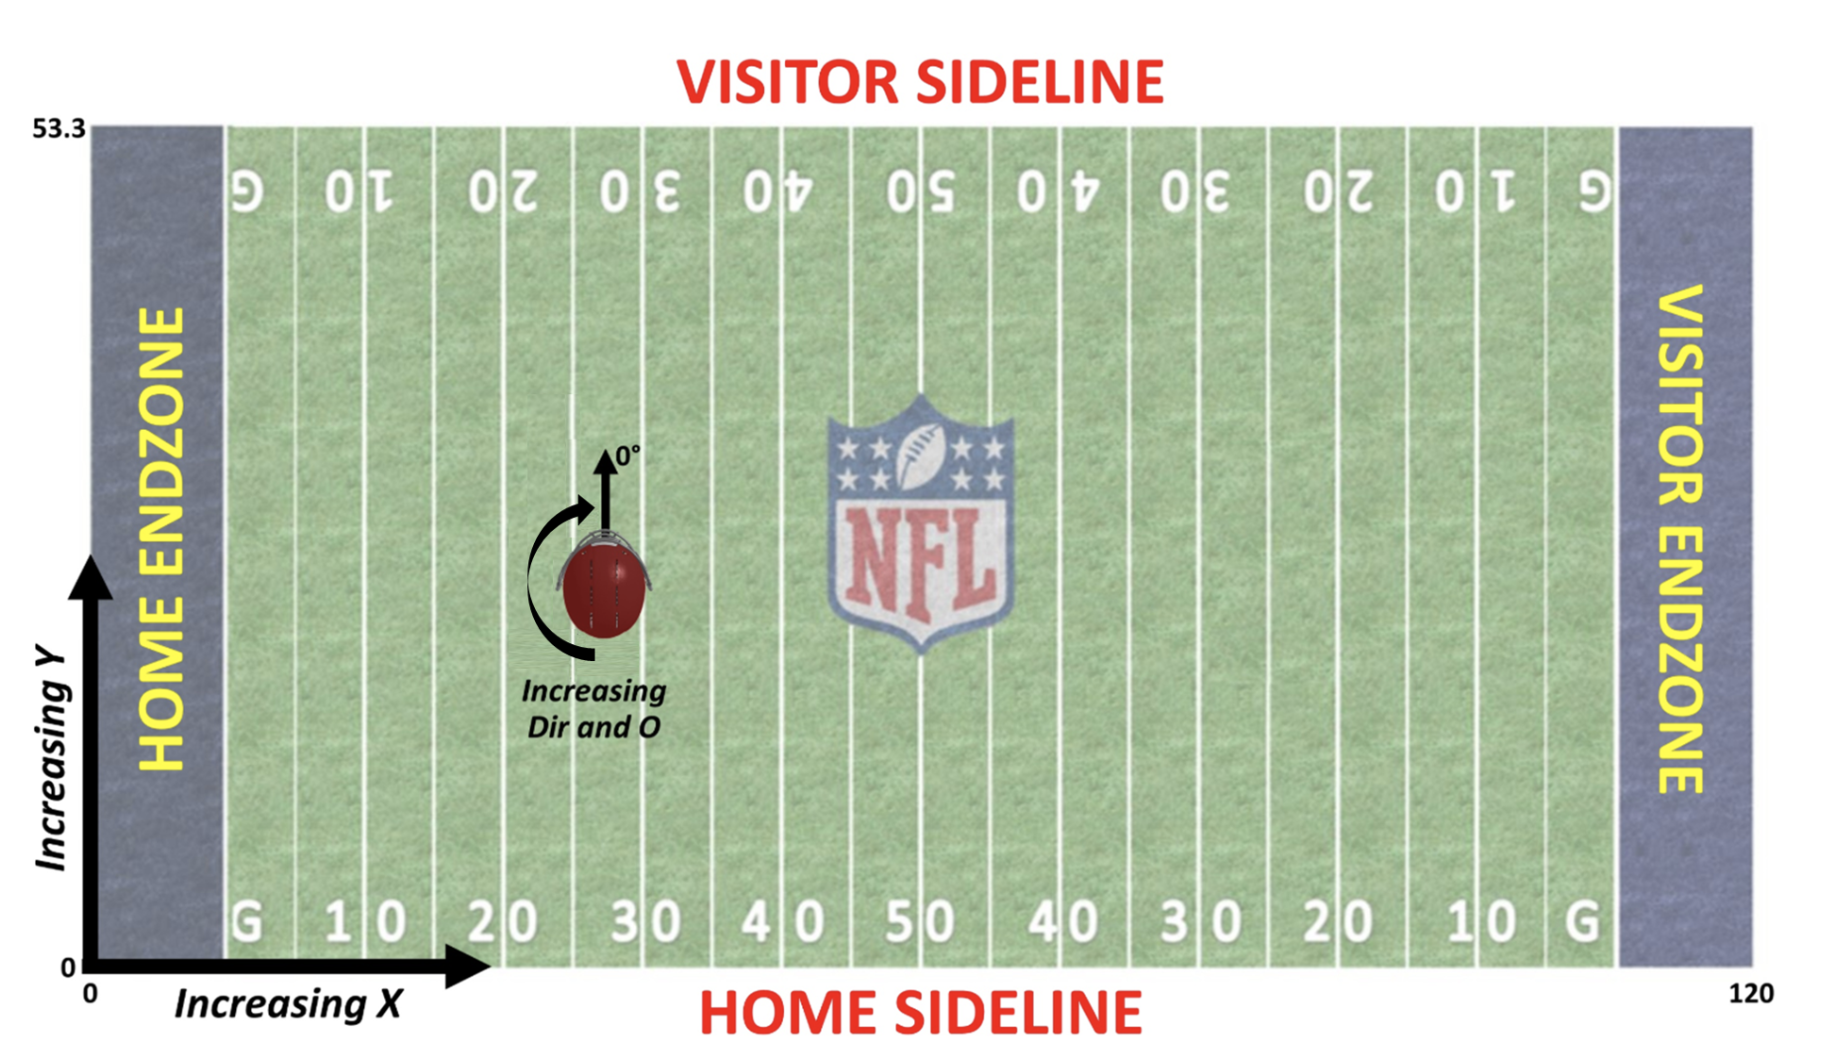

In [57]:
display_png(Image("./markdown/a.png"))

In [58]:

df.PlayDirection = df.PlayDirection.apply(lambda x: x.strip() == 'right')

In [59]:
#左方向に攻める人からしたらXの基準は逆になる
df['X'] = df.apply(lambda _row: _row.X if _row.PlayDirection else 120 - _row.X , axis=1)

In [60]:
df.PlayDirection.isnull().sum()

0

In [61]:
#　playの向きで変更するひつようがある
def convert_deg(angle, play_direction):
    if play_direction == False:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle

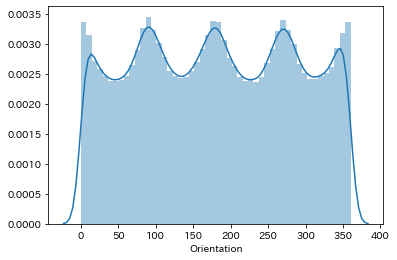

In [62]:
#不思議な分布
sns.distplot(df.Orientation.dropna())

In [63]:
df.Orientation = df.Orientation.fillna(270)
df.Dir = df.Dir.fillna(270)

In [64]:
#同様に選手の向き
df.Orientation = df.apply(lambda _row : convert_deg(_row.Orientation,_row.PlayDirection),axis = 1)
#選手の動きの向き
df.Dir = df.apply(lambda _row : convert_deg(_row.Dir,_row.PlayDirection),axis = 1)

## ボール
- 現在のボールの位置（選手にとって自サイドかor not）

In [65]:

df['BoulSide'] = df.FieldPosition == df.HomeTeamAbbr 

In [66]:
del df['FieldPosition']

In [67]:
df['isTeamHaveBoul'] = df.PossessionTeam == df.HomeTeamAbbr

In [68]:
del df['PossessionTeam']

## Yard

In [69]:
#発生したyardを調整
df['YardsLeft'] = df.apply( lambda _row : 100 - _row.YardLine if _row.Orientation else _row.YardLine, axis = 1 )
# train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
# train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

In [70]:
#　プレイ前の得点状況は四則演算レベルでしか特徴量生成できないので、そのまま
# set(df.HomeScoreBeforePlay.astype(str) +'-'+ df.VisitorScoreBeforePlay.astype(str))

## 時間

In [71]:
#時間系統
df['LagHandOff'] = df.TimeHandoff - df.TimeSnap


In [72]:
df.LagHandOff = df.LagHandOff.dt.seconds

In [73]:
del df['TimeSnap']
del df['TimeHandoff']

## personnel

In [74]:
#df_OffensePersonnel
# カテゴリに分類
df_OffensePersonnel = df.OffensePersonnel.str.replace(', ',',')
df_OffensePersonnel = pd.DataFrame(df_OffensePersonnel.str.split(','))

In [75]:
   
ls_dct_offPer = [ { 'idx':_idx, 'OffPer': { _item.split(' ')[1] :  _item.split(' ')[0] for _item in _row.OffensePersonnel }}  for _idx,_row in df_OffensePersonnel.iterrows()] 
df_PosOffer = pd.io.json.json_normalize(ls_dct_offPer)
df_PosOffer = df_PosOffer.fillna(0)
df_PosOffer = df_PosOffer.set_index('idx')

In [76]:
with open('./pickle/ls_dct_offPer.pickle','wb') as f:
    pickle.dump(ls_dct_offPer,f)

In [77]:
# df_DefensePersonnel
# カテゴリに分類
df_DefensePersonnel = df.DefensePersonnel.str.replace(', ',',')
df_DefensePersonnel = pd.DataFrame(df_DefensePersonnel.str.split(','))

In [78]:
   
ls_dct_DefPer = [ { 'idx':_idx, 'OffDef': { _item.split(' ')[1] :  _item.split(' ')[0] for _item in _row.DefensePersonnel }}  for _idx,_row in df_DefensePersonnel.iterrows()] 
df_PosDef = pd.io.json.json_normalize(ls_dct_DefPer)
df_PosDef = df_PosDef.fillna(0)
df_PosDef = df_PosDef.set_index('idx')

In [79]:
with open('./pickle/ls_dct_DefPer.pickle','wb') as f:
    pickle.dump(ls_dct_DefPer,f)

In [80]:
del df['DefensePersonnel']
del df['OffensePersonnel']

In [81]:
df = pd.concat([df,df_PosDef,df_PosOffer],axis=1)#df_PosOffer

In [82]:
for _col in list(df.columns):
    if 'OffDef' in _col:
        df[_col] = df[_col].astype(int)
    if 'OffPer' in _col:
        df[_col] = df[_col].astype(int)

## Stadium 

In [130]:

def convert_stadium(txt):
    txt = txt.lower() 
    txt = txt.replace(' ','')
    txt = txt.replace(',,,','')
    txt = txt.replace(',,','')
    txt = txt.replace('-','')
    txt = txt.replace('stadium','')
    txt = txt.replace('stdium','')
    txt = txt.replace('field','')
    txt = txt.replace('bank','')
    txt = txt.replace('dome','')
    txt = txt.replace('link','')
    txt = txt.replace('mercedesbenzsuper','mercedesbenz')
    txt = txt.replace('losangelesmemorialcoliesum','losangelesmemorialcoliseum')
    return txt
df.Stadium = df.Stadium.apply(lambda x : convert_stadium(x))

## Location

In [173]:

def convert_location(txt):
    txt = txt.lower() 
    txt = txt.replace(' ','')
    txt = txt.replace(',,,','')
    txt = txt.replace(',,','')
    txt = txt.replace(',','')
    txt = txt.replace('-','')
    txt = txt.replace('.','')
    txt = re.sub(r'oh\Z','ohio',txt)
    txt = txt.replace('ohio','')
    txt = re.sub(r'tx\Z','texs',txt)
    txt = re.sub(r'texas\Z','texs',txt)
    txt = txt.replace('texs','')
    txt = re.sub(r'fla\Z','florida',txt)
    txt = re.sub(r'fl\Z','florida',txt)
    txt = txt.replace('florida','')
    txt = re.sub(r'wa\Z','washinton',txt)
    txt = txt.replace('washinton','')  
    txt = re.sub(r'pa\Z','Pennsylvania',txt)
    txt = txt.replace('Pennsylvania','') 
    txt = re.sub(r'calif\Z','california',txt)
    txt = re.sub(r'ca\Z','california',txt)
    txt = txt.replace('california','') 
    txt = re.sub(r'nc\Z','northcarolina',txt)
    txt = re.sub(r'la\Z','losangels',txt)
    txt = txt.replace('losangels','') 
    txt = txt.replace('northcarolina','') 
    txt = txt.replace('baltimoremaryland','baltimoremd')
    txt = txt.replace('londonengland','london')
    return txt
df.Location = df.Location.apply(lambda x : convert_location(x))

## 欠損補完

In [85]:

df.Temperature = df.Temperature.fillna(df.Temperature.mean())
df.DefendersInTheBox = df.DefendersInTheBox.fillna(df.DefendersInTheBox.mean())
df.OffenseFormation = df.OffenseFormation.fillna('None')

### データの保存

In [175]:
with open('./pickle/df.pickle','wb') as f:
    pickle.dump(df,f)

In [172]:
with open('./pickle/df.pickle','rb') as f:
    df = pickle.load(f)

## 学習予測フェーズ

In [87]:
dct_ls_col_type = {}
for _col, _dtype in zip(df.columns,df.dtypes):
    _dtype = _dtype.name
    if _dtype in dct_ls_col_type.keys():
        dct_ls_col_type[_dtype].append(_col)
    else:
        dct_ls_col_type[_dtype] = [_col]

In [182]:
ls_cat_colDtype = ['bool','object','category']
y_col = 'Yards'
ls_remove_col = ['GameId', 'PlayId','DisplayName','PlayerCollegeName']
ls_remove_col.append(y_col)

ls_cat_col =  reduce( lambda a,b: a+b, [ dct_ls_col_type[_dtype_col] for _dtype_col in ls_cat_colDtype])
ls_num_col =  reduce( lambda a,b: a+b, [ dct_ls_col_type[_dtype_col] for _dtype_col in dct_ls_col_type.keys() if _dtype_col not in ls_cat_colDtype])
ls_cat_col = list(set(ls_cat_col) -set(ls_remove_col))
ls_num_col = list(set(ls_num_col) -set(ls_remove_col))
ls_use_col = ls_cat_col + ls_num_col

In [183]:
# ls_use_col

In [190]:
data = {}
data['y'] = copy.deepcopy(df.Yards)
data['X'] = {}
data['X']['num'] = copy.deepcopy(df[ls_num_col])
data['X']['cat'] = pd.get_dummies(df[ls_cat_col])

In [191]:
data['X'] = pd.concat([data['X']['cat'],data['X']['num']],axis=1)

In [192]:
list(data['X'].columns)

['Turf',
 'PlayDirection',
 'IsRusher',
 'isTeamHaveBoul',
 'BoulSide',
 'StadiumTypeFeature1_close',
 'StadiumTypeFeature1_open',
 'HomeTeamAbbr_ARI',
 'HomeTeamAbbr_ATL',
 'HomeTeamAbbr_BAL',
 'HomeTeamAbbr_BUF',
 'HomeTeamAbbr_CAR',
 'HomeTeamAbbr_CHI',
 'HomeTeamAbbr_CIN',
 'HomeTeamAbbr_CLE',
 'HomeTeamAbbr_DAL',
 'HomeTeamAbbr_DEN',
 'HomeTeamAbbr_GB',
 'HomeTeamAbbr_HOU',
 'HomeTeamAbbr_IND',
 'HomeTeamAbbr_JAX',
 'HomeTeamAbbr_KC',
 'HomeTeamAbbr_LA',
 'HomeTeamAbbr_LAC',
 'HomeTeamAbbr_MIA',
 'HomeTeamAbbr_NE',
 'HomeTeamAbbr_NO',
 'HomeTeamAbbr_NYG',
 'HomeTeamAbbr_NYJ',
 'HomeTeamAbbr_OAK',
 'HomeTeamAbbr_PHI',
 'HomeTeamAbbr_PIT',
 'HomeTeamAbbr_SEA',
 'HomeTeamAbbr_SF',
 'HomeTeamAbbr_TB',
 'HomeTeamAbbr_TEN',
 'HomeTeamAbbr_WAS',
 'Location_arlington',
 'Location_atlantaga',
 'Location_baltimoremd',
 'Location_carson',
 'Location_charlotte',
 'Location_chicagoil',
 'Location_cincinnati',
 'Location_cleveland',
 'Location_denverco',
 'Location_eastrutherfordnj',
 'Location

In [189]:
scaler = StandardScaler()
data['X'] = scaler.fit_transform(data['X'])
data['y'] = (data['y']).values

KeyError: 'X'

In [188]:
#　分割
ls_pre_idx,ls_sim_idx = train_test_split(range(len(data['X'])), test_size=0.7, shuffle = False )

KeyError: 'X'


## Light gbm

In [78]:
def diff(preds, data):
    y_true = data.get_label()


    return 'diff',sum(np.power((y_true - preds),2)),False

In [79]:
def do_lgbm(params,lgb_train,lgb_eval,evals_result):
        model = lgbm.train(
            params,
            lgb_train,
            num_boost_round=100,
            valid_sets=lgb_eval,
            valid_names=['eval'],
            early_stopping_rounds=10,
            evals_result=evals_result,
            feval=diff,
            verbose_eval = False
        )
        return model, evals_result

In [80]:

def test_lgbm(params):

    tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)
    ls_sum_sqare_error = []
    ls_all_test_idx = []
    for ls_train_idx, ls_test_idx in tqdm(tscv.split(ls_pre_idx)):
#         print(len(ls_train_idx),len(ls_test_idx))
        # create dataset for lightgbm
        lgb_train = lgbm.Dataset(data['X'][ls_train_idx], data['y'][ls_train_idx])
        lgb_eval = lgbm.Dataset(data['X'][ls_test_idx], data['y'][ls_test_idx], reference=lgb_train)
        evals_result = {}
        
        # train
        model, evals_result = do_lgbm(params,lgb_train,lgb_eval,evals_result)
        
        ls_sum_sqare_error.append(np.min(evals_result['eval']['diff']))
        ls_test_idx = np.append(ls_all_test_idx,ls_test_idx)
    return sum(ls_sum_sqare_error)/float(len(ls_test_idx))

In [81]:

tuned_parameters = [{
    'task' : ['train'],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'metric' : ['rmse'],#物によるけど、深く考えず外れ値をなくすことを考えう
    'num_leaves' : range(5,50,5),
    'learning_rate' : [0.01,0.05,0.1,0.5],#学習率
    'feature_fraction' : [0.9],
    'bagging_fraction' : [0.8],
    'bagging_freq': [5],
    'num_threads':[4]
    
}]


In [ ]:
{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 5, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 2.4761365581941335
    

In [83]:
ls_dct_param = ParameterGrid(tuned_parameters)
for dct_param in ls_dct_param:
    _rmse = test_lgbm(dct_param)
    print(str(dct_param)+' : '+str(_rmse))


{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 5, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 96.84015187855961



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 10, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 81.8674934335262



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 15, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 80.09472197210938



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 20, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 80.78659199986244



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 25, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 80.50262669973135



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 30, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 81.24174129998049



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 35, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 82.47327291717775



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 40, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 82.37205106115462



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'metric': 'rmse', 'num_leaves': 45, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 82.08215303740653



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 5, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 3.276091326542541



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 10, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 3.8982476435462465



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 15, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 5.020059074854835



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 20, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 6.987692771870536



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 25, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 6.8464490554735535



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 30, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 7.6903392517371465



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 35, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.841341752324555



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 40, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.729099586448482



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.05, 'metric': 'rmse', 'num_leaves': 45, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.798677819422254



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 5, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 2.4761365581941335



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 10, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 3.710686579153851



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 15, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 5.1105810223694395



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 20, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 6.603643643687387



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 25, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 7.042401682515123



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 30, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 6.685293435945847



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 35, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.53156624482649



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 40, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.725635798467847



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse', 'num_leaves': 45, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 9.085658220765591



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 5, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 3.447395033592335



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 10, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 3.1801116520425667



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 15, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 6.7307448838260155



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 20, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 7.601017593276699



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 25, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.05843153665182



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 30, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 7.801480207321774



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 35, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 8.410911639361172



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 40, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 10.261143671786465



{'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.5, 'metric': 'rmse', 'num_leaves': 45, 'num_threads': 4, 'objective': 'regression', 'task': 'train'} : 11.484285186675457


In [10]:
params = {
    'bagging_fraction': 0.8, 
    'bagging_freq': 5,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.9, 
    'learning_rate': 0.1, 
    'metric': 'rmse',
    'num_leaves': 5,
    'num_threads': 4, 
    'objective': 'regression', 
    'task': 'train'
} 

lgb_train = lgbm.Dataset(data['X'][ls_pre_idx], data['y'][ls_pre_idx])
lgb_test = lgbm.Dataset(data['X'][ls_sim_idx], data['y'][ls_sim_idx])

model, evals_result = do_lgbm(params,lgb_train,None,evals_result)

preds = model.predict(data['X'][ls_sim_idx], num_iteration=model.best_iteration)
y_test = data['y'][ls_sim_idx]

NameError: name 'ls_pre_idx' is not defined

In [118]:
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

## DNN

In [503]:
batch_size = 64

In [561]:
def build_model(version=1):
    if version == 1:
        x = keras.layers.Input(shape=[data['X'].shape[1]])
        fc1 = keras.layers.Dense(units=450, input_shape=[data['X'].shape[1]])(x)
        act1 = keras.layers.PReLU()(fc1)
        bn1 = keras.layers.BatchNormalization()(act1)
        dp1 = keras.layers.Dropout(0.55)(bn1)
        gn1 = keras.layers.GaussianNoise(0.15)(dp1)
        concat1 = keras.layers.Concatenate()([x, gn1])
        fc2 = keras.layers.Dense(units=600)(concat1)
        act2 = keras.layers.PReLU()(fc2)
        bn2 = keras.layers.BatchNormalization()(act2)
        dp2 = keras.layers.Dropout(0.55)(bn2)
        gn2 = keras.layers.GaussianNoise(0.15)(dp2)
        concat2 = keras.layers.Concatenate()([concat1, gn2])
        fc3 = keras.layers.Dense(units=400)(concat2)
        act3 = keras.layers.PReLU()(fc3)
        bn3 = keras.layers.BatchNormalization()(act3)
        dp3 = keras.layers.Dropout(0.55)(bn3)
        gn3 = keras.layers.GaussianNoise(0.15)(dp3)
        concat3 = keras.layers.Concatenate([concat2, gn3])
        output = keras.layers.Dense(units=199, activation='softmax')(concat2)
        model = keras.models.Model(inputs=[x], outputs=[output])
    if version==2:
        model = keras.Sequential()
        model.add(keras.layers.Dense(1000, activation = 'relu'))
        model.add(keras.layers.Dense(800, activation = 'relu'))
        model.add(keras.layers.Dense(100, activation =  'relu'))
        model.add(keras.layers.Dense(1))
    return model
 



In [566]:
# def train_model(X_train, y_train, X_val, y_val):
#     model = build_model()
#     model.summary()
#     model.compile(
#         optimizer='adam' ,
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     model.fit(X_train, y_train, epochs=200, validation_data=[X_val, y_val])
#     return model

# def train_model(X_train, y_train, X_val, y_val):
#     model = build_model(1)
#     model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-7), loss=crps)
#     er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
#     model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
#     return model

def train_model(X_train, y_train, X_val, y_val):
    model = build_model(2)
    optimizer = adam(lr=0.001, decay=1e-6)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=batch_size)
    return model



from keras.optimizers import adam

In [119]:
tscv = TimeSeriesSplit(n_splits=5)
models = []

for tr_idx, vl_idx in tscv.split(data['X']):
    
    x_tr, y_tr = data['X'][tr_idx], data['y'][tr_idx]
    x_vl, y_vl = data['X'][vl_idx], data['y'][vl_idx]

    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

In [ ]:
class RAdam(keras.optimizers.Optimizer):    
    """RAdam optimizer.
    # Arguments
        learning_rate: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        learning_rate = kwargs.pop('lr', learning_rate)
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = K.maximum(self.total_steps - warmup_steps, 1)
            decay_rate = (self.min_lr - lr) / decay_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr + decay_rate * K.minimum(t - warmup_steps, decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t))
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t))

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / (v_corr_t + self.epsilon), m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, learning_rate):
        self.learning_rate = learning_rate

    def get_config(self):
        config = {
            'learning_rate': float(K.get_value(self.learning_rate)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [279]:
#from https://www.kaggle.com/davidcairuz/nfl-neural-network-w-softmax
def crps(y_true, y_pred):
    return K.mean(K.square(y_true - K.cumsum(y_pred, axis=1)), axis=1)


array([ 8,  8,  8, ..., 11, 11, 11])

In [184]:
dct_ls_col_type = {}
for _col, _dtype in zip(df.columns,df.dtypes):
    _dtype = _dtype.name
    if _dtype in dct_ls_col_type.keys():
        dct_ls_col_type[_dtype].append(_col)
    else:
        dct_ls_col_type[_dtype] = [_col]

In [185]:
for _col in dct_ls_col_type['object']:
    display( pd.DataFrame(df[_col].value_counts()).T ,)
    print(len(df[_col].unique()))

,home,away
Team,221166,221166


2


,Joe Thuney,Tom Brady,Shaq Mason,Michael Thomas,David Andrews,Jamal Adams,Ben Jones,Josh Kline,Ronnie Stanley,Garett Bolles,Nate Solder,Kevin Byard,Jordan Poyer,Rodney Hudson,DeAndre Hopkins,Max Unger,Kiko Alonso,Philip Rivers,Ryan Ramczyk,Tre'Davious White,D.J. Swearinger,A.J. Cann,Nick Martin,Russell Wilson,Jahleel Addae,Drew Brees,Brandin Cooks,Ryan Jensen,Blake Bortles,Kelvin Beachum,Taylor Lewan,Joe Schobert,Derek Carr,Casey Hayward,Matt Skura,Justin Simmons,Brandon Brooks,Quinton Spain,Alejandro Villanueva,Jordan Mills,Darron Lee,Jason Kelce,Micah Hyde,Ha Ha Clinton-Dix,Josh Norman,Morris Claiborne,Rob Havenstein,Germain Ifedi,Darian Stewart,Adoree' Jackson,Charles Leno Jr.,Marcus Mariota,Avery Williamson,Xavien Howard,Cody Whitehair,Justin Britt,Eric Weddle,Benardrick McKinney,Bobby Massie,Laken Tomlinson,Myles Jack,Blake Martinez,Mike Pouncey,Kyle Fuller,Anthony Castonzo,Maurkice Pouncey,Jalen Ramsey,Rob Gronkowski,Rodger Saffold,Jermey Parnell,Reshad Jones,Brandon Marshall,Eli Manning,Ron Parker,Ben Roethlisberger,Tashaun Gipson,Joe Staley,James Hurst,T.J. Carrie,Mitchell Schwartz,Demario Davis,Virgil Green,Joel Bitonio,JC Tretter,Kevin Zeitler,Chris Hubbard,Kelechi Osemele,Russell Okung,Johnathan Hankins,David DeCastro,Dan Feeney,Sean Davis,Trent Brown,Marcus Gilchrist,Tony Jefferson,Telvin Smith,Eric Fisher,Nick Boyle,Ramon Foster,Clint Boling,Jared Goff,Tre Boston,Morgan Moses,C.J. Mosley,Jabaal Sheard,Jason Pierre-Paul,Andrus Peat,Melvin Ingram,Matt Paradis,J.R. Sweezy,Marcus Peters,Von Miller,Devin McCourty,Brian Winters,Leonard Williams,Logan Ryan,Bobby Wagner,Andrew Whitworth,Dion Dawkins,Kareem Jackson,Jon Bostic,Larry Warford,Tahir Whitehead,Malcolm Butler,Gabe Jackson,Lane Johnson,A.J. Bouye,William Jackson,Brandon Carr,Buster Skrine,Wesley Woodyard,Landon Collins,Spencer Pulley,Jadeveon Clowney,Chris Harris,Todd Davis,Tyler Higbee,Patrick Omameh,Ndamukong Suh,Duane Brown,Donovan Smith,Damarious Randall,Eddie Jackson,John Sullivan,James Carpenter,Vince Williams,Nelson Agholor,Senio Kelemete,Brandon Williams,Ryan Kerrigan,Laremy Tunsil,Christian Kirksey,Dre Kirkpatrick,Patrick Chung,Joe Flacco,Travis Kelce,Marcus Maye,Shaquill Griffin,Antonio Brown,Bud Dupree,Preston Smith,Justin Houston,Deshaun Watson,Keenan Allen,Stephon Gilmore,Karl Joseph,Shawn Williams,DeForest Buckner,Jack Conklin,Andrew Norwell,Zach Brown,Robert Woods,Demaryius Thomas,Cameron Heyward,Zay Jones,Jarvis Landry,Jabrill Peppers,Janoris Jenkins,Jonnu Smith,Jason McCourty,Zach Ertz,James Bradberry,Barry Church,Mitchell Trubisky,T.Y. Hilton,Jurrell Casey,Tyrann Mathieu,Jamon Brown,Marcus Williams,Michael Schofield,Cam Newton,Brandon Shell,T.J. McDonald,T.J. Watt,Josh Hill,Zach Fulton,Jesse Davis,Connor McGovern,Carlos Dunlap,Bradley Roby,Kendall Fuller,Zach Cunningham,Myles Garrett,Antonio Morrison,Russell Bodine,Jordan Jenkins,Steven Nelson,Khalil Mack,Tyrell Williams,Reggie Nelson,Carson Wentz,Case Keenum,Dalvin Tomlinson,Jesse James,Mike Adams,Ereck Flowers,Corey Linsley,Calais Campbell,Patrick Peterson,Marcus Cannon,Trevon Coley,Alec Ogletree,Alshon Jeffery,Kenny Wiggins,D.J. Reader,Tramon Williams,Alex Smith,Joe Haeg,Nick Vigil,Melvin Gordon,Akiem Hicks,Jamie Collins,Preston Brown,Josh Doctson,Brent Grimes,Joe Haden,Jordy Nelson,Davon Godchaux,Kenny Stills,Eric Reid,Andy Dalton,Kenny Moore,Luke Kuechly,Jermaine Kearse,Cameron Jordan,Jordan Howard,Jack Doyle,Tyler Lockett,Prince Amukamara,Trey Flowers,...,James Looney,K.J. Brent,Vince Mayle,Will Beatty,Demetrious Cox,Nolan Carroll,Bryan Braman,Keenan Reynolds,Quincy Adeboyejo,Joe Vellano,Ahmad Thomas,Russell Gage,Peyton Thompson,Jordan Williams,Akeem Hunt,Ian Silberman,Cameron Lynch,Matt Dickerson,Mark Walton,Nicholas Grigsby,Corn Elder,Denzel Rice,Conor McDermott,Joe Jones,Armani Watts,Rickey Hatley,Trent Scott,Chad Thomas,Forrest Lamp,Cooper Rush,Max McCaffrey,Albert McClellan,DeAndre Houston-Carson,Pete Robertson,Claude Pelon,Aaron Wallace,Nigel Harris,Keishawn Bierria,Raven Greene,Walt

2215


,SINGLEBACK,SHOTGUN,I_FORM,PISTOL,JUMBO,WILDCAT,EMPTY,ACE
OffenseFormation,189024,134728,94534,11572,10252,1694,418,22


9


,Alabama,Ohio State,Louisiana State,Georgia,Florida,Florida State,Clemson,Notre Dame,Oklahoma,Stanford,Wisconsin,South Carolina,Michigan,Penn State,Southern California,Oregon,California,Iowa,Miami,UCLA,Washington,Texas,North Carolina,Mississippi,Texas A&M,North Carolina State,Utah,Mississippi State,Michigan State,Louisville,Nebraska,Auburn,Tennessee,Boise State,Central Florida,Missouri,Pittsburgh,USC,Kentucky,West Virginia,Virginia Tech,Boston College,Arkansas,Vanderbilt,Rutgers,Texas Christian,Colorado,Temple,Georgia Tech,Oregon State,Central Michigan,Illinois,Purdue,Oklahoma State,Maryland,Cincinnati,Utah State,LSU,Kansas State,Louisiana Tech,Virginia,Arizona State,Southern Methodist,Indiana,Fresno State,Southern Mississippi,Duke,Baylor,Arizona,Texas Tech,Delaware,Houston,South Florida,Wyoming,Nevada,Memphis,Kent State,Brigham Young,Toledo,Connecticut,Minnesota,North Dakota State,Kansas,Wake Forest,Northwestern,Western Kentucky,West Alabama,Colorado State,Miami (Fla.),Florida Atlantic,Iowa State,Rice,Samford,Florida International,Appalachian State,Colorado State-Pueblo,Marshall,Harvard,Idaho,Western Michigan,Texas-El Paso,East Carolina,Grand Valley State,South Carolina State,Northern Iowa,Eastern Washington,Syracuse,Northern Illinois,San Jose State,Middle Tennessee,"Regina, Can.",Tulane,Massachusetts,Valdosta State,Alabama-Birmingham,Washington State,Ohio,Idaho State,Arkansas State,Troy,Coastal Carolina,Illinois State,Chattanooga,Montana,"Miami, O.",Miami (Ohio),Army,Sacramento State,Newberry,South Dakota State,Portland State,Cornell,Buffalo,San Diego State,Hillsdale,North Alabama,North Carolina A&T,Sam Houston State,Western Oregon,James Madison,Shippensburg,Pennsylvania,Bucknell,Towson,Bloomsburg,Tulsa,Hobart,North Carolina-Charlotte,New Mexico,Montana State,Monmouth (N.J.),Brown,Louisiana Coll.,Howard,William & Mary,Lindenwood,Southeastern Louisiana,William Penn,Akron,Minn. State-Mankato,Kentucky Wesleyan,North Texas,Missouri Southern,Ball State,Texas State,Slippery Rock,Grambling,Saginaw Valley State,Arkansas-Pine Bluff,Georgia Southern,California-Irvine,Eastern Michigan,West Georgia,Louisiana-Lafayette,Abilene Christian,Alabama State,Greenville,"Manitoba, Can.",Eastern Illinois,Ohio U.,Texas-San Antonio,"California, Pa.",Pittsburg State,McGill,Wisconsin-Milwaukee,Northwest Missouri State,Canisius,Georgia State,Tennessee State,North Carolina Central,Ashland,Delaware State,"Albany State, Ga.",Middle Tennessee State,New Mexico State,Missouri Western State,Southern Utah,Southern Illinois,South Dakota,Old Dominion,Central Missouri,Mount Union,"Laval, Can.",Columbia,Tiffin University,East Central,Mars Hill,Beloit,Hampton,Maine,Villanova,Nevada-Las Vegas,New Hampshire,Princeton,Bowling Green State,Richmond,Missouri Southern State,West Texas A&M,Bethune-Cookman,"Western State, Colo.",Air Force,Yale,Washburn,Central Arkansas,Michigan Tech,Southern Arkansas,Furman,Belhaven,Fort Hays State,Assumption,Winston-Salem State,Stillman,Ouachita Baptist,Northwestern State-Louisiana,Midwestern State,Virginia Commonwealth,Nicholls State,Eastern Kentucky,South Alabama,Missouri State,Henderson State,Tennessee-Chattanooga,Weber State,Nebraska-Omaha,Alabama A&M,Youngstown State,San Diego,Concordia-St. Paul,Marist,Northeast Mississippi CC,No College,"Monmouth, N.J.",Grambling State,Jacksonville,Stephen F. Austin St.,Citadel,Wagner,Drake,"Augustana, S.D.",Virginia State,Lamar,Presbyterian,Prairie View,Albany,Wofford,Bowie State,Northwestern (Ia),Stony Brook,Jacksonville State,Limestone,Fordham,North Greenville,Wis.-Platteville,Southeast Missouri,Hawaii,Shepherd,Southern Connecticut State,Wisconsin-Whitewater,Frostburg State,Southern University,St. Francis (PA),Humboldt State,Mary Hardin-Baylor,Ferris State,Western Carolina,Indiana State,Chadron State,Navy,Arkansas-Monticello,Liberty,Marian (Ind.),Incarnate Word (Tex.),Azusa Pacific,Western Illinois,Texas Southern,Holy Cross,Cal Poly,Stetson,"Concordia, Minn",Alcorn State
PlayerCollegeName,14281,12

300


,CB,WR,G,T,DE,DT,OLB,TE,C,FS,RB,QB,SS,ILB,MLB,NT,LB,OT,FB,OG,DB,S,HB,SAF,DL
Position,48945,46166,36678,36079,31278,30516,29352,28820,21093,20995,20789,20214,18158,16628,8385,7372,6085,5432,2722,2655,1778,1558,604,19,11


25


,SF,NE,BUF,BAL,SEA,CIN,IND,DEN,OAK,NYG,NYJ,JAX,CLE,HOU,TEN,NO,LAC,MIA,WAS,KC,CHI,GB,PIT,TB,PHI,CAR,LA,ARI,DAL,ATL
HomeTeamAbbr,17402,17248,17204,17094,16962,16588,16544,16478,16456,16280,16236,15972,15928,15884,15862,15554,15532,15400,15356,15334,15334,15312,14850,14696,14476,14036,13112,7414,4246,3542


30


,IND,DEN,OAK,TEN,LAC,NYJ,HOU,JAX,BAL,CLE,WAS,NE,KC,ATL,PIT,MIA,DAL,NYG,BUF,CIN,LA,ARI,DET,SF,MIN,SEA,NO,CHI,PHI,TB,CAR,GB
VisitorTeamAbbr,16764,16698,16478,16478,15664,15444,15224,15180,14696,14520,14432,14410,14256,14124,14080,14080,13882,13794,13728,13662,13596,13464,13288,13178,12562,12386,11990,11638,11286,10802,10384,10164


32


,MetLife Stadium,Levis Stadium,Gillette Stadium,New Era Field,Lucas Oil Stadium,Nissan Stadium,Mercedes-Benz Superdome,Paul Brown Stadium,FedExField,Soldier Field,Arrowhead Stadium,Heinz Field,Raymond James Stadium,StubHub Center,CenturyLink Field,Hard Rock Stadium,Lincoln Financial Field,Lambeau Field,Bank of America Stadium,Oakland-Alameda County Coliseum,NRG Stadium,MetLife,Los Angeles Memorial Coliseum,M&T Bank Stadium,Sports Authority Field at Mile High,FirstEnergy Stadium,Broncos Stadium at Mile High,TIAA Bank Field,M&T Stadium,State Farm Stadium,Wembley Stadium,EverBank Field,AT&T Stadium,FirstEnergy,NRG,Everbank Field,University of Phoenix Stadium,Mercedes-Benz Stadium,First Energy Stadium,CenturyField,FirstEnergyStadium,Paul Brown Stdium,CenturyLink,Twickenham Stadium,M & T Bank Stadium,Lambeau field,Los Angeles Memorial Coliesum,Broncos Stadium At Mile High,Twickenham,Estadio Azteca,Mercedes-Benz Dome,Oakland Alameda-County Coliseum,Metlife Stadium
Stadium,19998,17402,17248,17204,16544,15862,15554,15444,15356,15334,15334,14850,14696,14630,14586,14564,14476,14300,14036,13706,11968,11682,11132,11000,8536,7722,6952,6446,5016,4598,4576,4246,4246,4246,3916,3432,2816,2684,1694,1254,1166,1144,1122,1100,1078,1012,1012,990,968,902,858,858,836


53


,"East Rutherford, NJ","Santa Clara, CA","Indianapolis, Ind.","Denver, CO","Baltimore, Md.","Nashville, TN",Orchard Park NY,"Landover, MD","Green Bay, WI","Foxborough, MA","Tampa, FL","Carson, CA","Seattle, WA","Oakland, CA","Chicago, IL","Cincinnati, Ohio","Kansas City, MO","Miami Gardens, Fla.",Pittsburgh,"Philadelphia, Pa.","Jacksonville, FL","Los Angeles, Calif.","New Orleans, LA","Houston, TX","Charlotte, North Carolina","Cleveland, Ohio","Glendale, AZ","Houston, Texas","London, England","Charlotte, NC","Arlington, Texas","Atlanta, GA","Cleveland,Ohio","New Orleans, La.",Seattle,"Cincinnati, OH","East Rutherford, N.J.","Foxborough, Ma","Orchard Park, NY","Pittsburgh, PA","E. Rutherford, NJ","Philadelphia, PA",Cleveland Ohio,"Kansas City, MO",New Orleans,"Baltimore, Maryland","Miami Gardens, FLA",Cleveland,London,"Los Angeles, CA",Jacksonville Florida,"Jacksonville, Fl",Mexico City,"Jacksonville, Florida","Cleveland, OH",Chicago. IL
Location,29040,17402,16544,16478,16016,15862,15488,15356,15312,15224,14696,14630,14630,14564,14498,14476,14190,13486,13178,13156,11352,11176,11110,9746,8844,8316,7414,6138,5676,5192,4246,3542,3476,3300,2332,2112,2024,2024,1716,1672,1452,1320,1166,1144,1144,1078,1078,1034,968,968,968,902,902,902,836,836


56


In [186]:
dct_ls_col_type.keys()

dict_keys(['int64', 'object', 'float64', 'bool', 'category'])

In [187]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,DisplayName,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,DefendersInTheBox,PlayDirection,Yards,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,Turf,Temperature,Humidity,WindSpeed,direction_s,direction_w,direction_e,direction_n,PlayerBMI,PlayerAge,IsRusher,sun,cloud,rain,BoulSide,isTeamHaveBoul,YardsLeft,LagHandOff,OffDef.DL,OffDef.LB,OffDef.DB,OffDef.OL,OffPer.RB,OffPer.TE,OffPer.WR,OffPer.OL,OffPer.DL,OffPer.LB,OffPer.DB,OffPer.QB,GameClockTimeZone
0,2017090700,20170907000118,away,46.090,34.840,1.690,1.130,0.400,278.010,182.820,Eric Berry,29,2017,35,1,3,2,0,0,SHOTGUN,6.000,False,8,72,212,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",False,63.000,77.000,8.000,0.000,0.000,0.000,0.000,28.749,28.693,False,0.000,0.000,0.000,True,False,65,1,2,3,6,0,1,1,3,0,0,0,0,0,"(12:00:00, 15:00:00]"
1,2017090700,20170907000118,away,45.330,32.640,0.420,1.350,0.010,332.390,161.300,Allen Bailey,97,2017,35,1,3,2,0,0,SHOTGUN,6.000,False,8,75,288,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",False,63.000,77.000,8.000,0.000,0.000,0.000,0.000,35.994,28.457,False,0.000,0.000,0.000,True,False,65,1,2,3,6,0,1,1,3,0,0,0,0,0,"(12:00:00, 15:00:00]"
2,2017090700,20170907000118,away,46.000,33.200,1.220,0.590,0.310,356.990,157.270,Justin Houston,50,2017,35,1,3,2,0,0,SHOTGUN,6.000,False,8,75,270,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",False,63.000,77.000,8.000,0.000,0.000,0.000,0.000,33.744,28.630,False,0.000,0.000,0.000,True,False,65,1,2,3,6,0,1,1,3,0,0,0,0,0,"(12:00:00, 15:00:00]"
3,2017090700,20170907000118,away,48.540,27.700,0.420,0.540,0.020,0.230,254.360,Derrick Johnson,56,2017,35,1,3,2,0,0,SHOTGUN,6.000,False,8,75,245,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",False,63.000,77.000,8.000,0.000,0.000,0.000,0.000,30.620,34.795,False,0.000,0.000,0.000,True,False,65,1,2,3,6,0,1,1,3,0,0,0,0,0,"(12:00:00, 15:00:00]"
4,2017090700,20170907000118,away,50.680,35.420,1.820,2.430,0.160,347.370,195.690,Ron Parker,38,2017,35,1,3,2,0,0,SHOTGUN,6.000,False,8,72,206,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",False,63.000,77.000,8.000,0.000,0.000,0.000,0.000,27.936,30.062,False,0.000,0.000,0.000,True,False,65,1,2,3,6,0,1,1,3,0,0,0,0,0,"(12:00:00, 15:00:00]"
